In [2]:
!python -m pip install pyyaml==5.1

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'



  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-j8tfgf02
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-j8tfgf02

  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl.metadata (370 bytes)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached bl

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [17]:
import os
import copy
import torch
import cv2
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog, detection_utils as utils
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader

# Define the dataset mapper with streamlined preprocessing
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Custom preprocessing
    preprocessed_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Simple RGB conversion
    
    # Minimal transformations
    transform_list = [
        T.Resize((800, 600)),  # Resize to fixed dimensions
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),  # Horizontal flips only
    ]
    preprocessed_image, transforms = T.apply_transform_gens(transform_list, preprocessed_image)
    dataset_dict["image"] = torch.as_tensor(preprocessed_image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, preprocessed_image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, preprocessed_image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Register your dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train/_annotations.coco.json", "train")
register_coco_instances("my_dataset_valid", {}, "valid/_annotations.coco.json", "valid")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # Use smaller model
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_valid",)
cfg.DATALOADER.NUM_WORKERS = 4  # Optimize for parallel data loading
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # Increase batch size
cfg.SOLVER.BASE_LR = 0.002  # Learning rate
cfg.SOLVER.MAX_ITER = 2500  # Reduce iterations for faster training
cfg.SOLVER.STEPS = [1500, 2000]  # Adjust learning rate decay steps
cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Save checkpoints frequently
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Reduce ROI proposals per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Adjust to your dataset
cfg.MODEL.BACKBONE.FREEZE_AT = 2  # Freeze backbone layers for efficiency

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)  # Start fresh training
trainer.train()


[12/12 03:38:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 220MB/s]                             
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pr

[12/12 03:38:48 d2.engine.train_loop]: Starting training from iteration 0
[12/12 03:39:06 d2.utils.events]:  eta: 0:37:48  iter: 19  total_loss: 2.627  loss_cls: 1.167  loss_box_reg: 0.3627  loss_rpn_cls: 0.7236  loss_rpn_loc: 0.2837    time: 0.9180  last_time: 0.9285  data_time: 0.0342  last_data_time: 0.0189   lr: 3.9962e-05  max_mem: 13697M
[12/12 03:39:25 d2.utils.events]:  eta: 0:37:33  iter: 39  total_loss: 1.731  loss_cls: 0.6961  loss_box_reg: 0.6059  loss_rpn_cls: 0.195  loss_rpn_loc: 0.2221    time: 0.9194  last_time: 0.9322  data_time: 0.0224  last_data_time: 0.0246   lr: 7.9922e-05  max_mem: 13697M
[12/12 03:39:43 d2.utils.events]:  eta: 0:37:30  iter: 59  total_loss: 1.711  loss_cls: 0.5872  loss_box_reg: 0.7483  loss_rpn_cls: 0.1135  loss_rpn_loc: 0.2267    time: 0.9216  last_time: 0.9248  data_time: 0.0234  last_data_time: 0.0193   lr: 0.00011988  max_mem: 13697M
[12/12 03:40:02 d2.utils.events]:  eta: 0:37:15  iter: 79  total_loss: 1.571  loss_cls: 0.5123  loss_box_reg:

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

[12/12 04:18:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [19]:
test_metadata = MetadataCatalog.get("my_dataset_test")


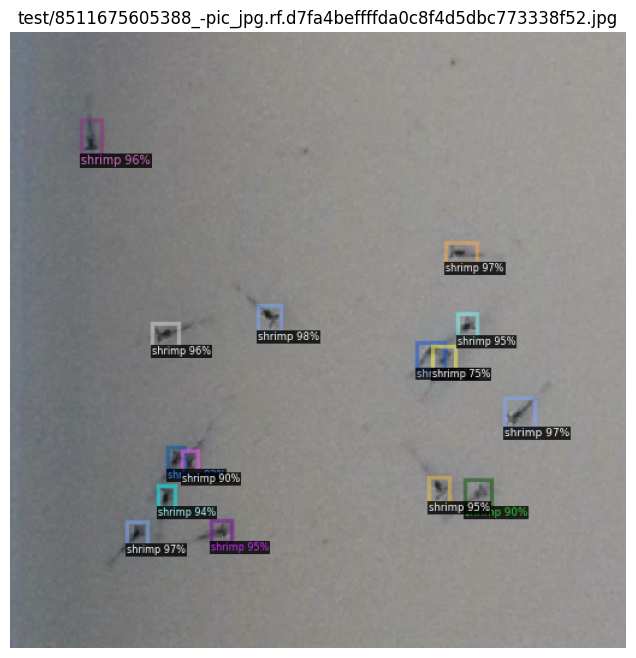

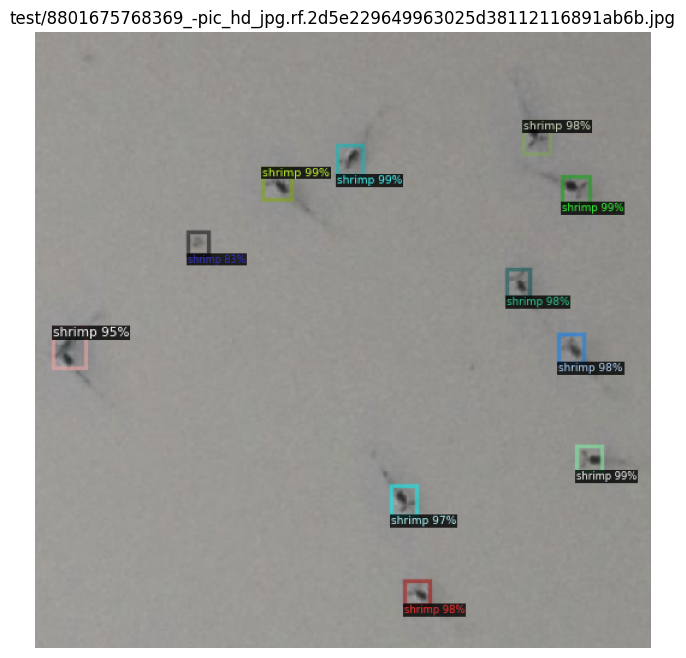

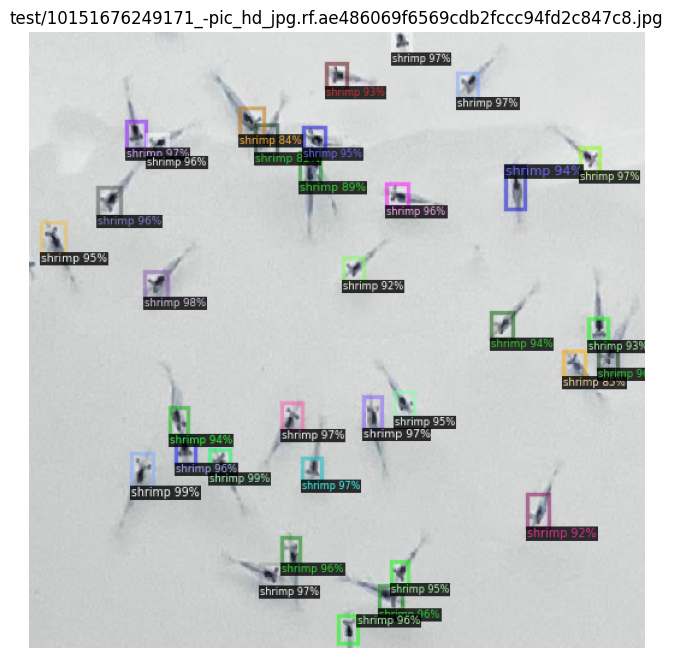

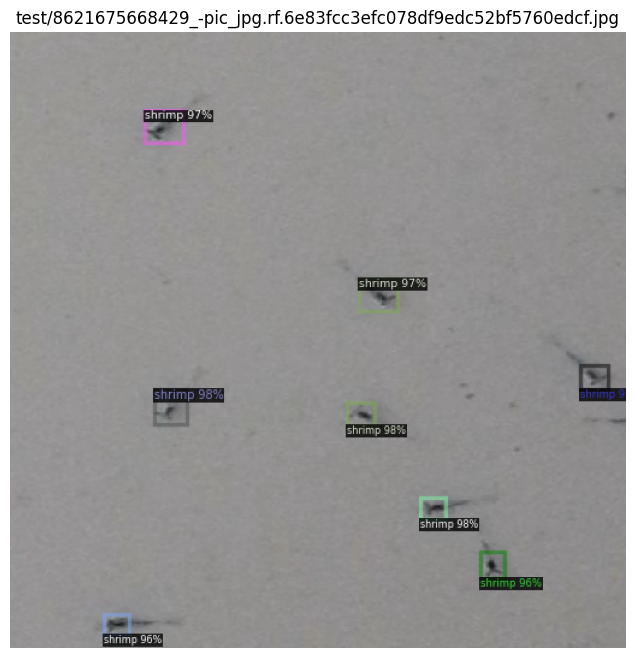

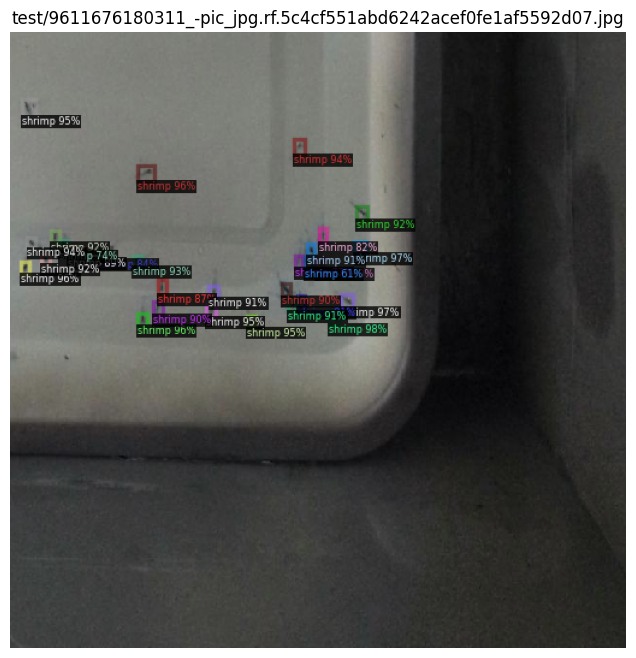

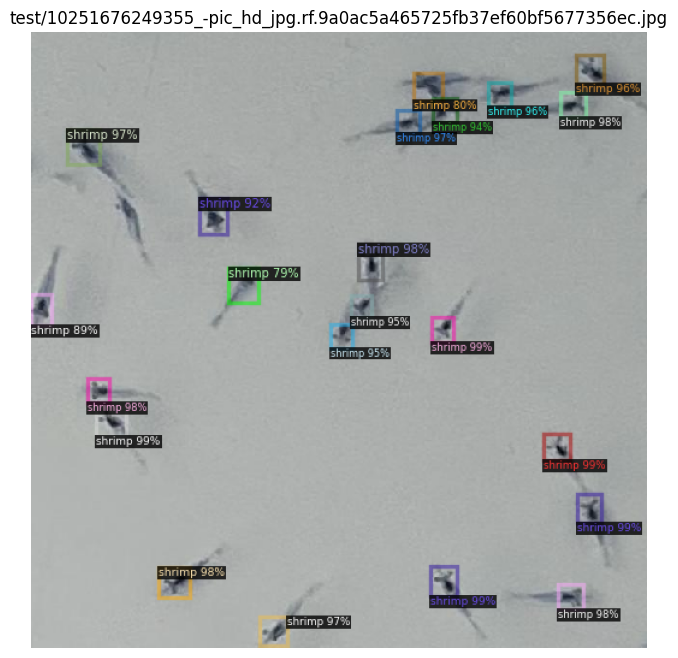

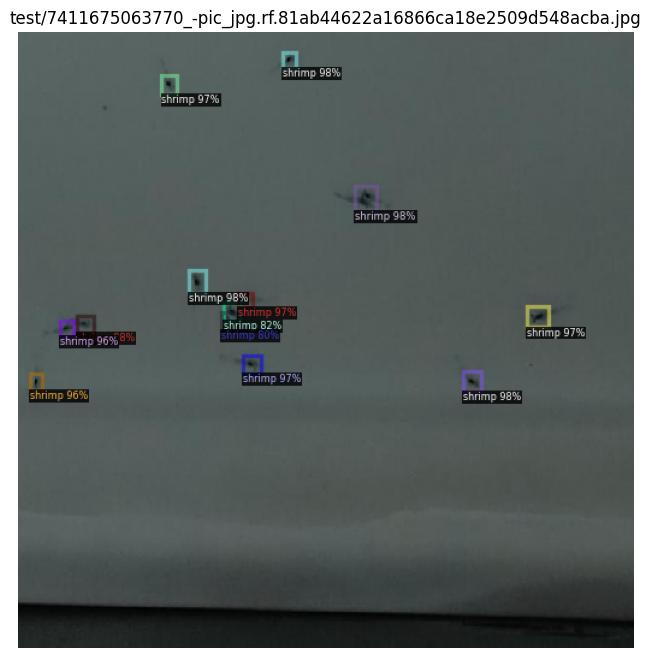

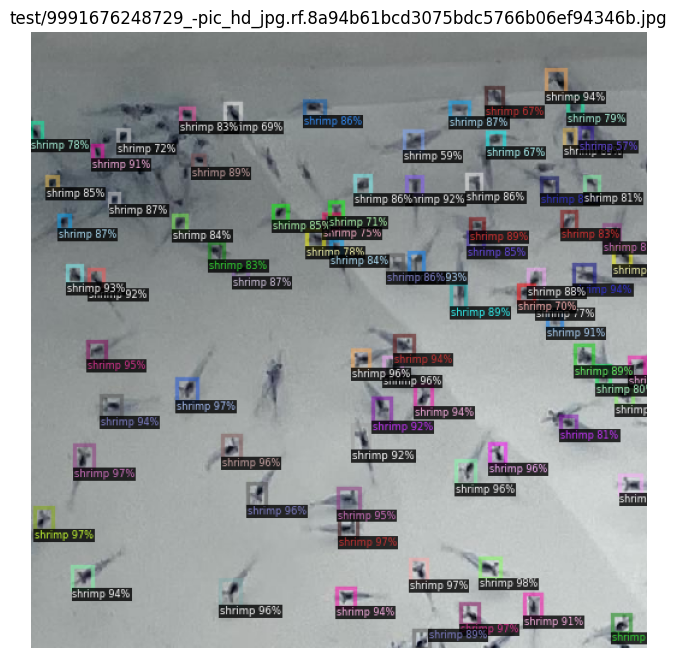

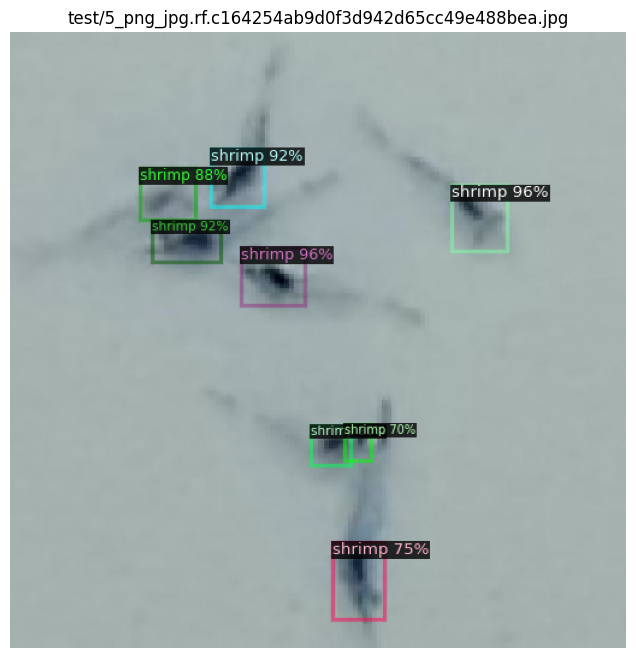

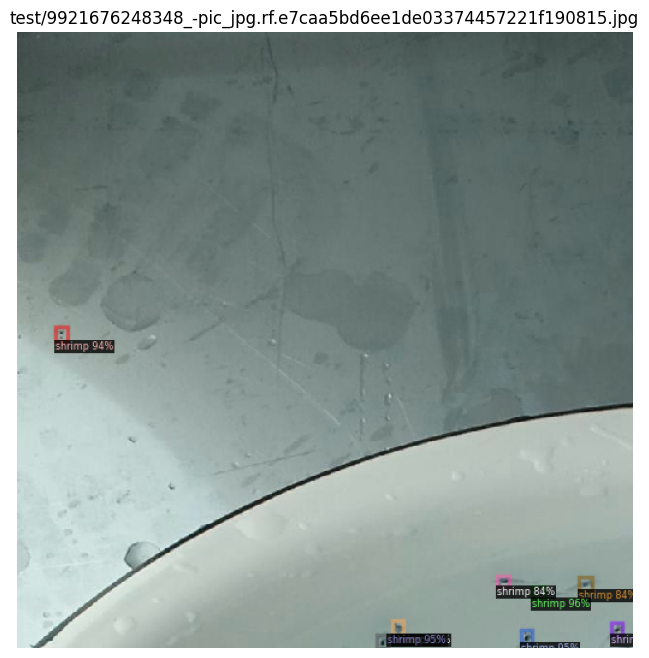

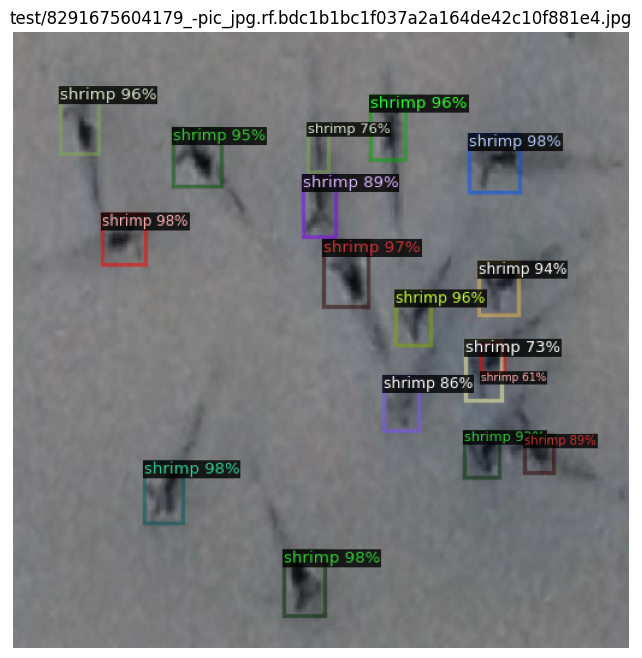

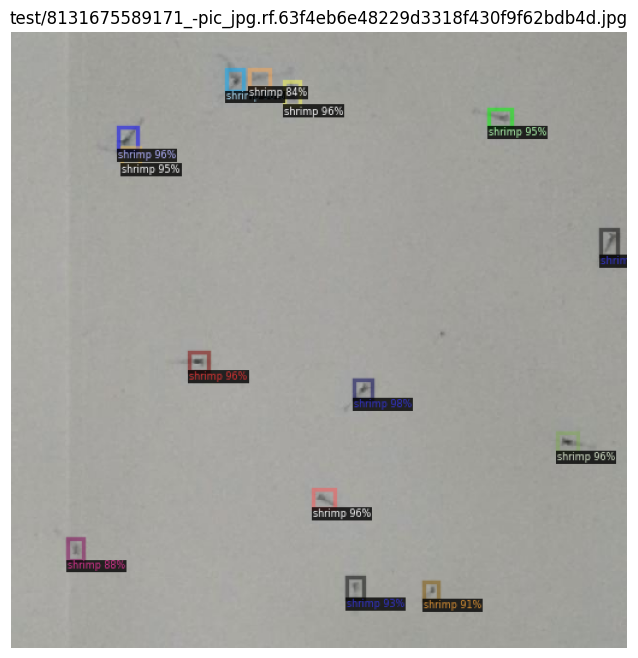

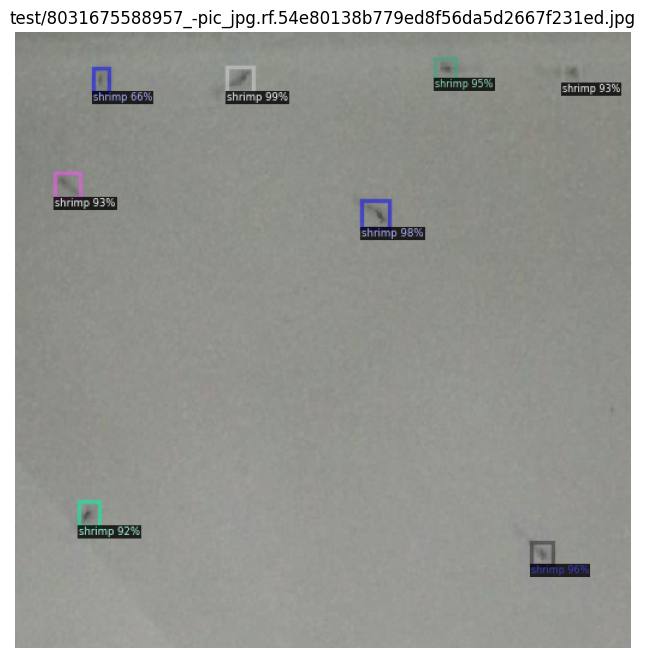

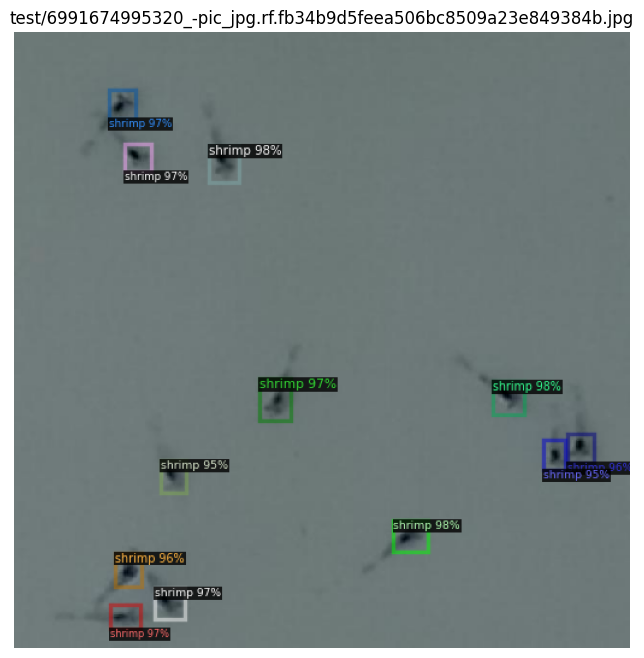

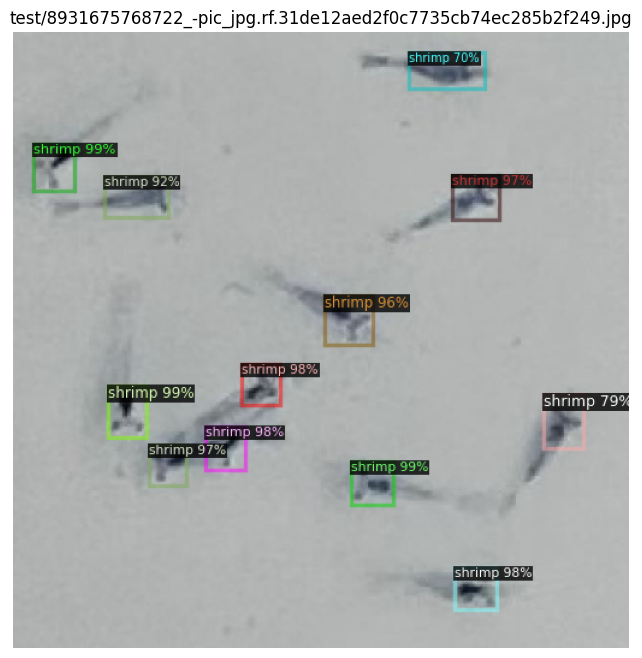

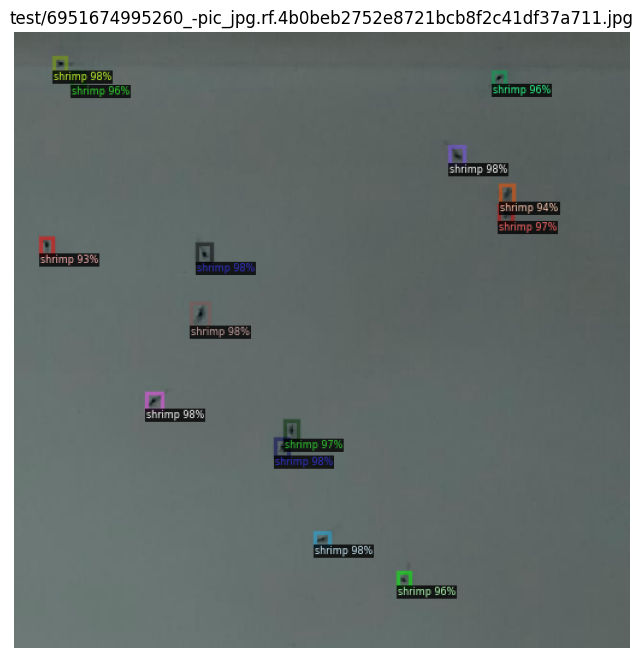

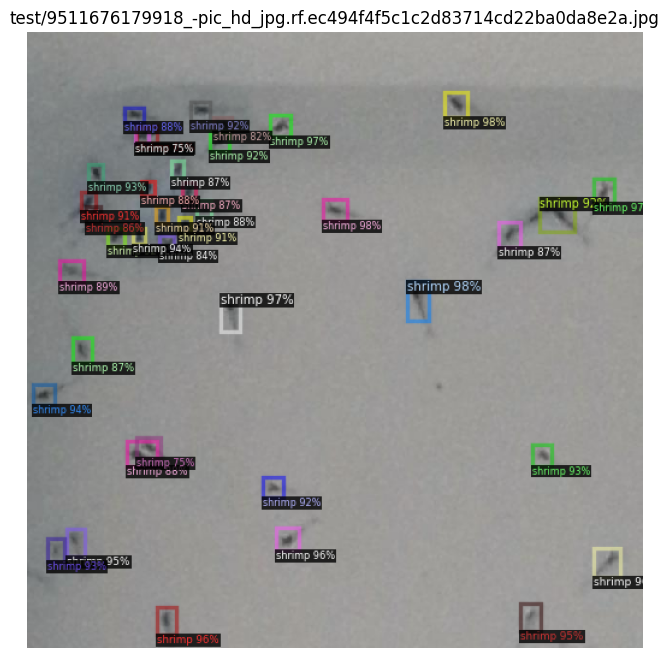

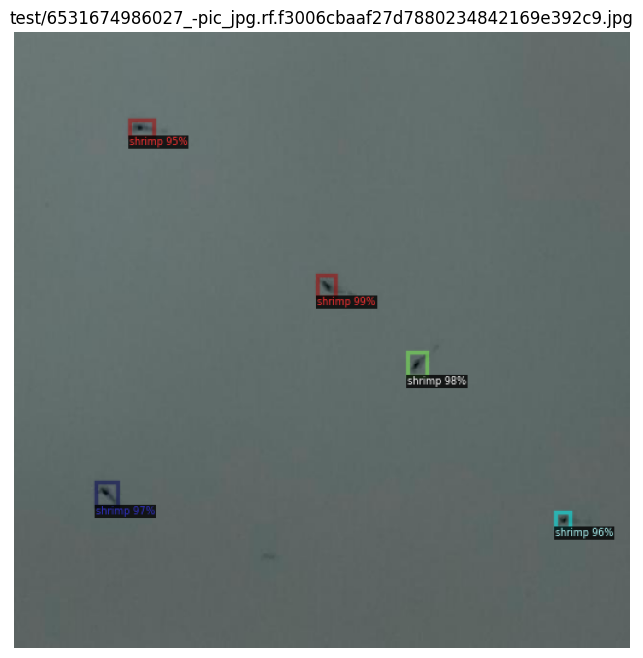

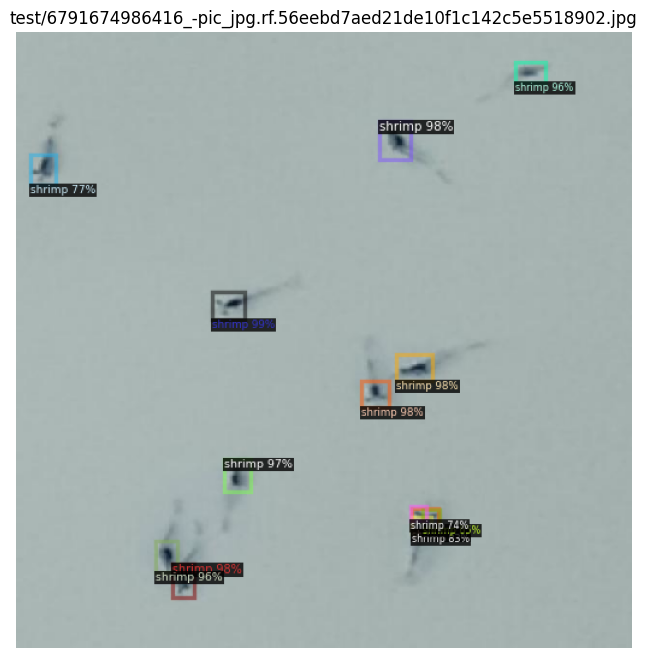

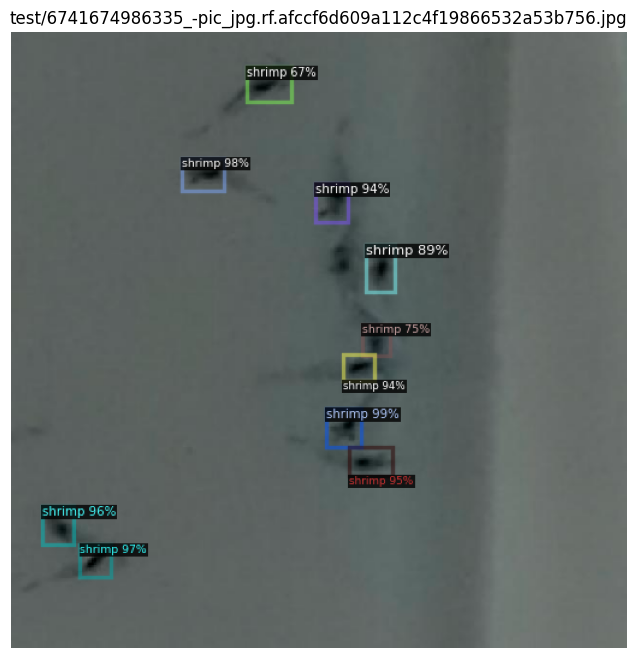

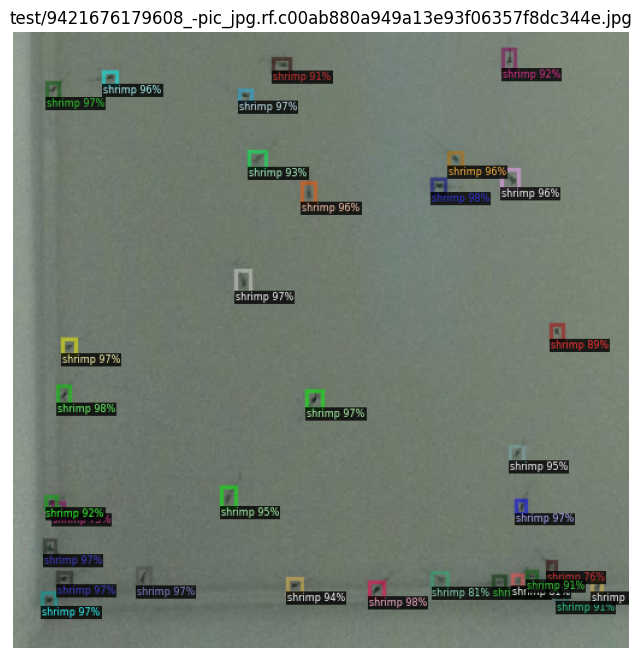

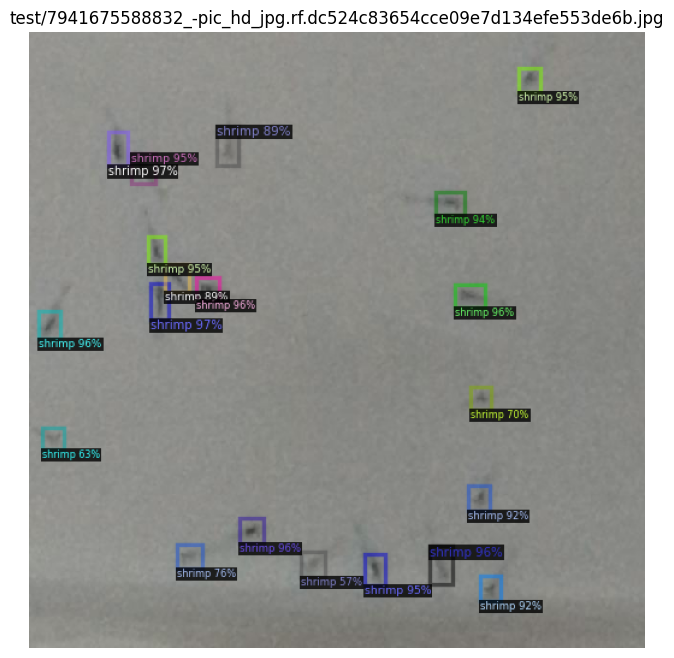

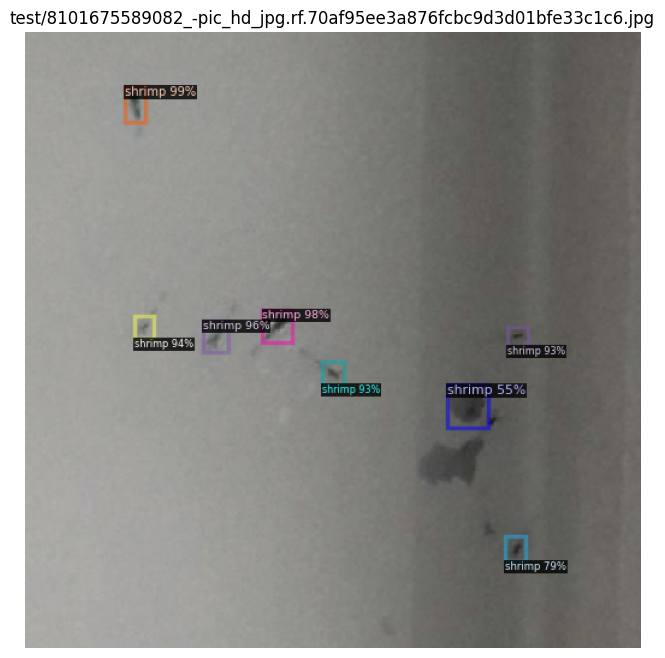

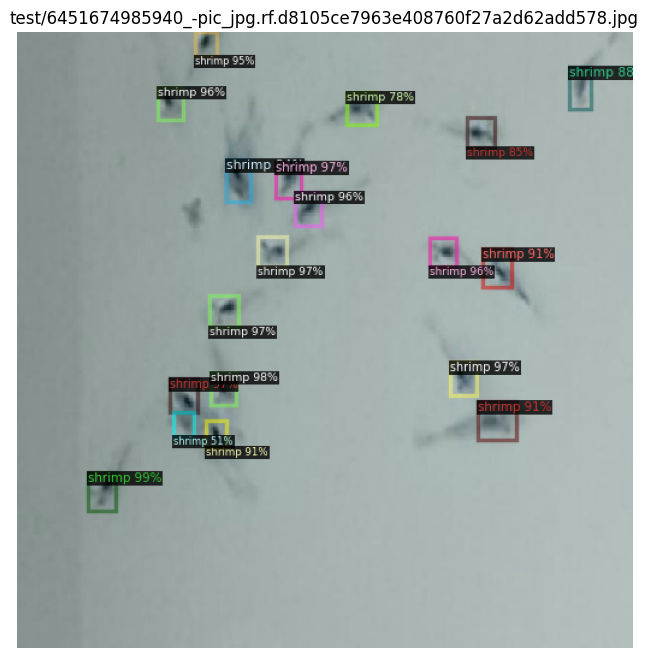

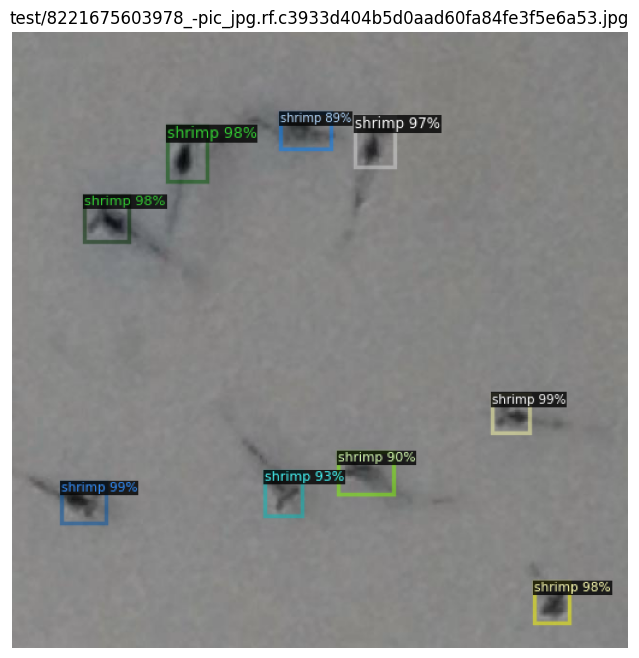

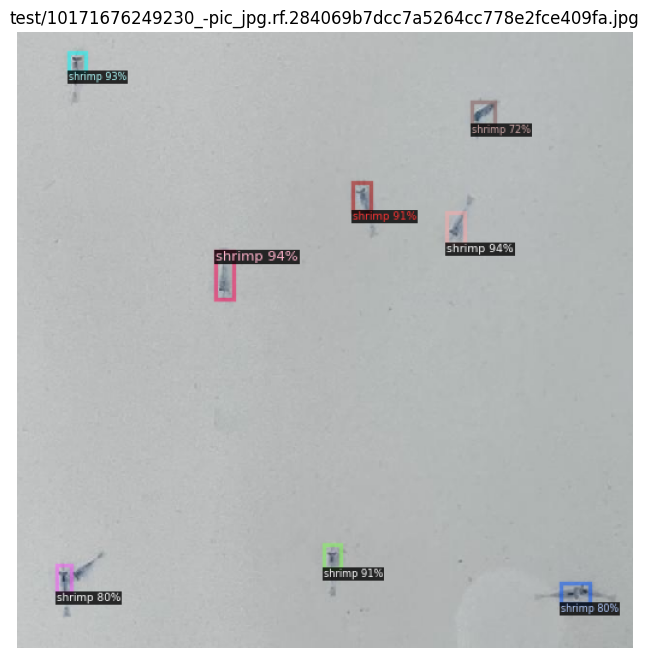

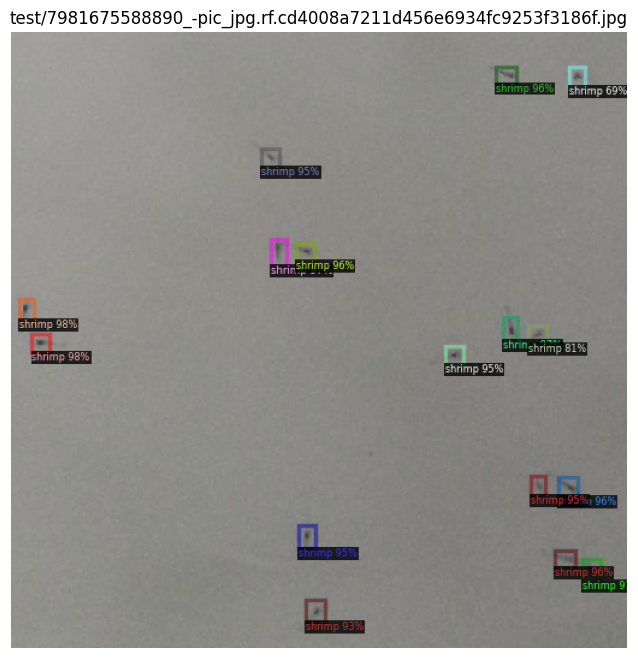

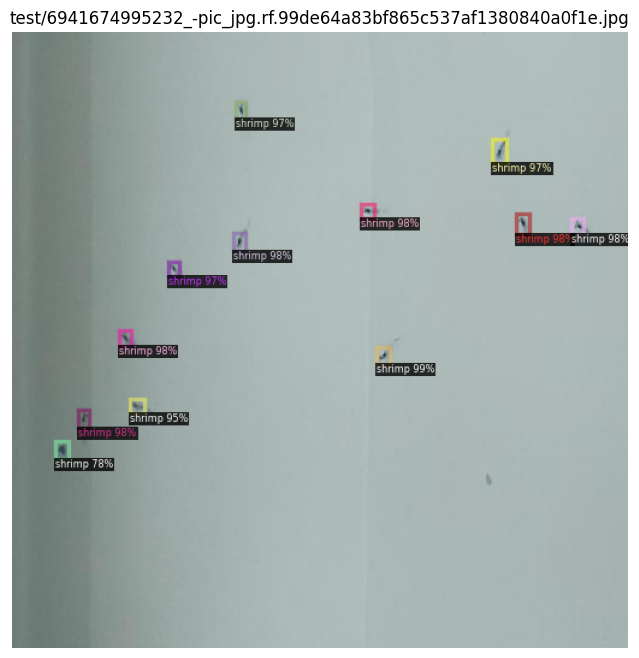

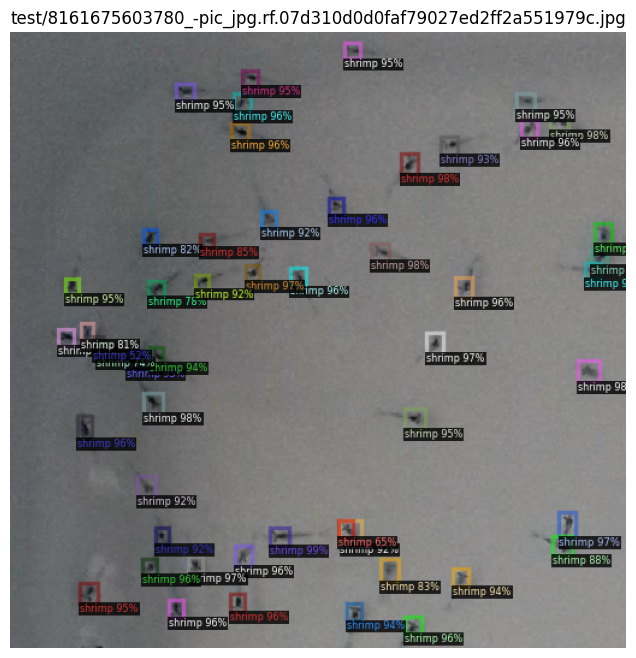

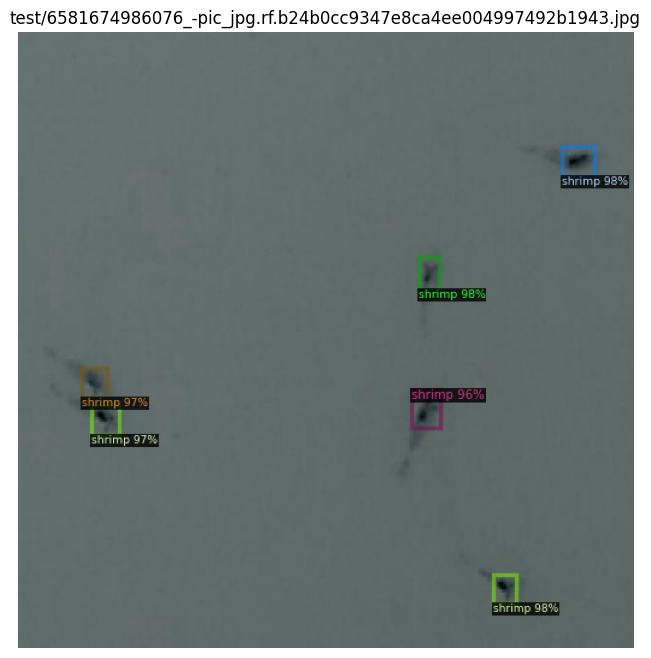

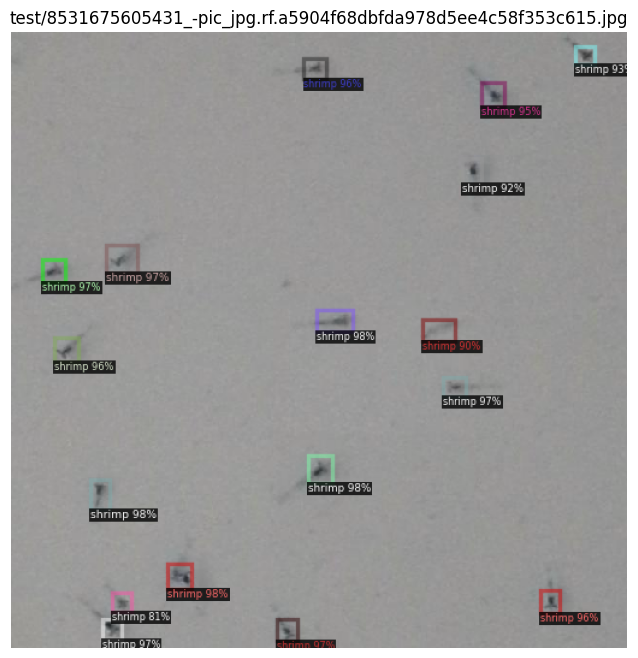

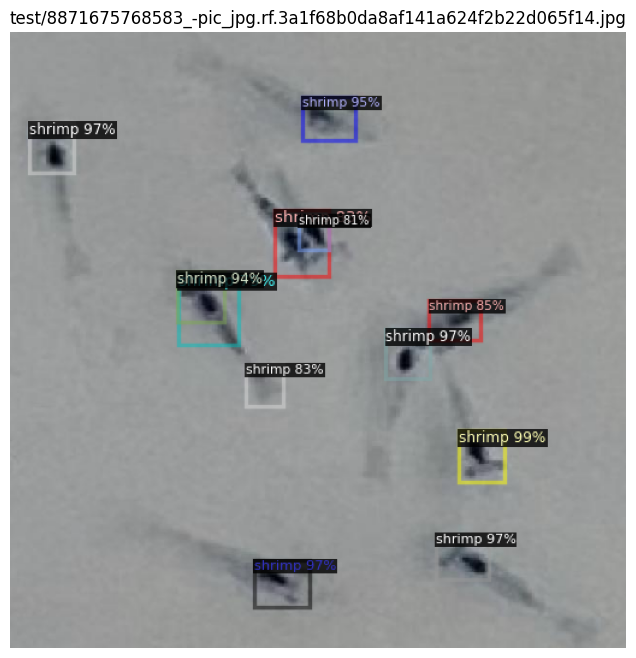

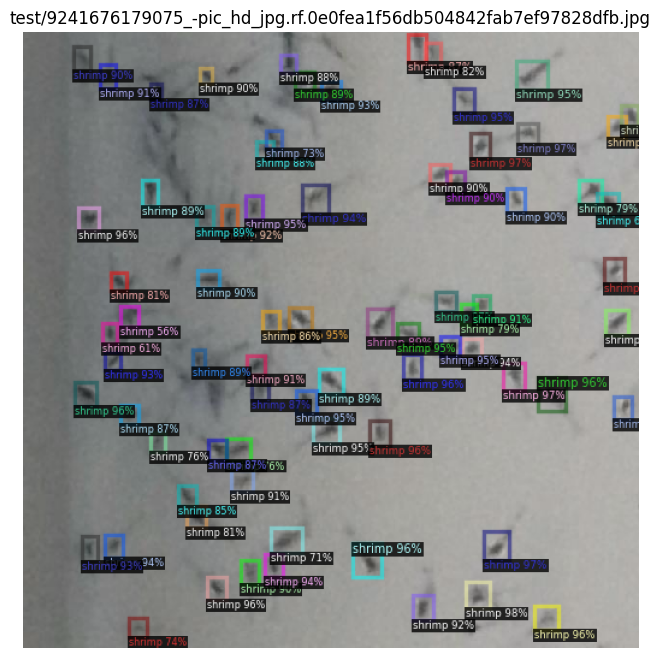

In [20]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('test/*jpg'):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Use matplotlib to display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.title(imageName)  # Optional: add title to the image
    plt.show()


In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [12/12 04:18:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/12 04:18:20 d2.data.datasets.coco]: Loaded 33 images in COCO format from test/_annotations.coco.json
[12/12 04:18:20 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   shrimp   | 0            |   shrimp   | 711          |
|            |              |            |              |
|   total    | 711          |            |              |
[12/12 04:18:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/12 04:18:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/12 04:18:20 d2.data.common]: Serializing 33 elements to byte tensors and concatenati

In [10]:
f = open('config2.yml', 'w')
f.write(cfg.dump())
f.close()

In [11]:
pip install supervision

Note: you may need to restart the kernel to use updated packages.


SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Number of bounding boxes: 1588


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


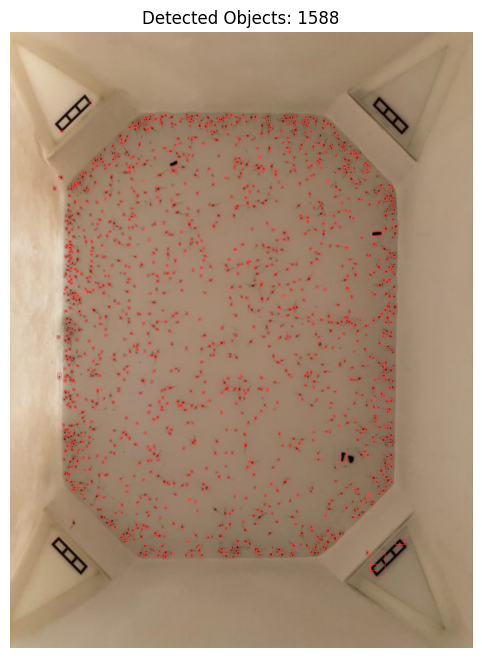

Annotated image saved to /teamspace/studios/this_studio/out.JPG


In [1]:
import supervision as sv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Load the Detectron2 model
def get_model(config_path: str, weights_path: str):
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # Set threshold for this model
    predictor = DefaultPredictor(cfg)
    return predictor

# Path to the config and weights files
config_path = "/teamspace/studios/this_studio/config2.yml"
weights_path = "/teamspace/studios/this_studio/output/model_final.pth"
model = get_model(config_path, weights_path)

# Load the image
image_path = "/teamspace/studios/this_studio/test im.jpg"
image = cv2.imread(image_path)

# Callback function to perform inference on image slices
def slicer_callback(slice: np.ndarray) -> sv.Detections:
    outputs = model(slice)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else np.array([])
    scores = instances.scores.numpy() if instances.has("scores") else np.array([])
    classes = instances.pred_classes.numpy() if instances.has("pred_classes") else np.array([])
    
    if boxes.shape[0] == 0:  # No detections
        return sv.Detections.empty()
    
    # Convert the outputs to a compatible format for sv.Detections
    detection_data = {
        "xyxy": boxes,
        "confidence": scores,
        "class_id": classes
    }
    detections = sv.Detections(**detection_data)
    return detections

# Create InferenceSlicer without the overlap_filter_strategy parameter
slicer = sv.InferenceSlicer(
    callback=slicer_callback,
    slice_wh=(512, 512),
    overlap_ratio_wh=(0.75, 0.75)
)
detections = slicer(image)

# Count the number of bounding boxes
num_detections = len(detections.xyxy)
print(f"Number of bounding boxes: {num_detections}")

# Annotate the original image with detections
annotator = sv.BoundingBoxAnnotator()
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)

# Save the annotated image
output_path = "/teamspace/studios/this_studio/out.JPG"
cv2.imwrite(output_path, annotated_frame)

# Display the annotated image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Detected Objects: {num_detections}")
plt.show()

print(f"Annotated image saved to {output_path}")

In [2]:
import supervision as sv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Load the Detectron2 model
def get_model(config_path: str, weights_path: str):
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # Set threshold for this model
    predictor = DefaultPredictor(cfg)
    return predictor

# Path to the config and weights files
config_path = "/teamspace/studios/this_studio/config2.yml"
weights_path = "/teamspace/studios/this_studio/output/model_final.pth"
model = get_model(config_path, weights_path)

# Load the image
image_path = "/teamspace/studios/this_studio/test im.jpg"
image = cv2.imread(image_path)

# Callback function to perform inference on image slices
def slicer_callback(slice: np.ndarray) -> sv.Detections:
    outputs = model(slice)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else np.array([])
    scores = instances.scores.numpy() if instances.has("scores") else np.array([])
    classes = instances.pred_classes.numpy() if instances.has("pred_classes") else np.array([])
    
    if boxes.shape[0] == 0:  # No detections
        return sv.Detections.empty()
    
    # Convert the outputs to a compatible format for sv.Detections
    detection_data = {
        "xyxy": boxes,
        "confidence": scores,
        "class_id": classes
    }
    detections = sv.Detections(**detection_data)
    
    # Apply post-processing to the detections
    filtered_detections = post_process_detections(detections)
    
    return filtered_detections

def post_process_detections(detections, min_size=10, max_size=100, aspect_ratio_range=(0.5, 2.0)):
    """
    Apply post-processing to the detections to remove false positives.
    
    Parameters:
    detections (sv.Detections): The detections to be post-processed.
    min_size (int): Minimum size of the bounding box (in pixels).
    max_size (int): Maximum size of the bounding box (in pixels).
    aspect_ratio_range (tuple): Acceptable range of aspect ratios for the bounding boxes.
    
    Returns:
    sv.Detections: The post-processed detections.
    """
    # Apply Non-Maximum Suppression
    # Handle different OpenCV versions 
    if cv2.__version__.startswith('4.'):
        keep_indices, _ = cv2.dnn.NMSBoxes(detections.xyxy.tolist(), detections.confidence.tolist(), 0.4, 0.4)
    else:
        keep_indices = cv2.dnn.NMSBoxes(detections.xyxy.tolist(), detections.confidence.tolist(), 0.4, 0.4)
    
    # If no indices, return empty detections
    if len(keep_indices) == 0:
        return sv.Detections.empty()
    
    # Flatten the indices if they're nested
    if isinstance(keep_indices[0], np.ndarray):
        keep_indices = [idx[0] for idx in keep_indices]
    
    # Filter by size and aspect ratio
    filtered_xyxy = []
    filtered_confidence = []
    filtered_class_id = []
    
    for i in keep_indices:
        x1, y1, x2, y2 = detections.xyxy[i]
        width = x2 - x1
        height = y2 - y1
        aspect_ratio = width / height
        
        if min_size <= width <= max_size and min_size <= height <= max_size and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
            filtered_xyxy.append([x1, y1, x2, y2])
            filtered_confidence.append(detections.confidence[i])
            filtered_class_id.append(detections.class_id[i])
    
    # Handle case where no detections pass filtering
    if not filtered_xyxy:
        return sv.Detections.empty()
    
    filtered_detections = sv.Detections(
        xyxy=np.array(filtered_xyxy),
        confidence=np.array(filtered_confidence),
        class_id=np.array(filtered_class_id)
    )
    
    return filtered_detections

# Create InferenceSlicer 
slicer = sv.InferenceSlicer(
    callback=slicer_callback,
    slice_wh=(512, 512),
    overlap_ratio_wh=(0.75, 0.75)
)
detections = slicer(image)

# Count the number of bounding boxes
num_detections = len(detections.xyxy)
print(f"Number of bounding boxes: {num_detections}")

# Annotate the original image with detections
annotator = sv.BoundingBoxAnnotator()
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)

# Save the annotated image
output_path = "/teamspace/studios/this_studio/out.JPG"
cv2.imwrite(output_path, annotated_frame)

# Display the annotated image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Detected Objects: {num_detections}")
plt.show()

print(f"Annotated image saved to {output_path}")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx